# BGU, Mini Project, Topics in Network Security, 2024b
Author: Yagel Nahshon (207055781)

Lecturer: Doron Ofek

Date: August 17, 2024

## Project Overview:

This project aims to build an Intrusion Detection System (IDS) that can detect different types of attacks in network traffic. 
We will use machine learning techniques to find the best model that can accurately detect attacks in real-time.
The goal is to develop a model that can detect attacks in real-time and identify the type of attack to take appropriate action.
The dataset used in this project is the CICIDS2017 dataset, which contains collection of network traffic data, including both normal and malicious traffic. 
The project involves data preprocessing, feature selection, model Training, hyperparameter tuning and model evaluation.

### CICIDS2017 Dataset:
The CICIDS2017 dataset was designed to provide researchers with a realistic and detailed dataset for testing and evaluating intrusion detection systems (IDS). The dataset was created by the Canadian Institute for Cybersecurity (CIC) and was generated by capturing network traffic over several days, where each day includes specific attack scenarios mixed with normal network activity. The dataset contains over 80 features, including time, source IP, destination IP, protocol, port number, and various statistical features that describe the network traffic.

The CICIDS2017 dataset is available in several formats:
1. **Raw Network Captured Data (PCAPs)**: This format contains raw packet capture data, which can be analyzed at the packet level using tools like Wireshark. 
2. **Generated Labelled Flows**: This format aggregates the raw packet data into network flows, each of which represents a sequence of packets between two endpoints. The flows are labeled as either benign or malicious.
3. **Machine Learning CSV**: This format further processes the labeled flows into a flat CSV file, with features specifically chosen for machine learning tasks. It is ready to be used directly in machine learning models without requiring additional preprocessing.

For this project, I chose the **Generated Labelled Flows** format because it offers a balance between raw data and preprocessed features, allowing for greater flexibility and control in preprocessing.

### Challenges Faced During the Project
At the beginning of the project, I tried creating my own dataset to simulate realistic attack scenarios, but I quickly realized that I cant generate the attacks effectively. This led me to explore established datasets and found several options. Eventually I chose the CICIDS2017.

While working with CICIDS2017, I encountered significant data imbalance, which initially made me consider using the preprocessed Machine Learning CSV format instead of the Generated Labelled Flows format. However, I successfully managed to preprocess the data as needed and address the imbalance, as demonstrated later in the project.

Additionally, the enormous size of the dataset required extensive processing time whenever I wanted to test even minor changes. so I used a relatively smaller subset of the data to ensure I could manage the workload with the available resources. This approach allowed me to make the necessary adjustments without being overwhelmed by the dataset's size.

-----


In [13]:
#importing necessary libraries that will be used throughout the project
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

warnings.filterwarnings('ignore') # for ignoring warnings to keep the notebook clean (relevant issues are handled in later sections)

## Data Loading and Merging
NOTE: The original dataset can be found at https://www.unb.ca/cic/datasets/ids-2017.html

The dataset is split multiple files, so we need to merge them into a single file for easier processing:

In [14]:
folder_path = "GeneratedLabelledFlows/TrafficLabelling"
file_names = [
    "Monday-WorkingHours.pcap_ISCX.csv",
    "Tuesday-WorkingHours.pcap_ISCX.csv",
    "Wednesday-workingHours.pcap_ISCX.csv",
    "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    "Friday-WorkingHours-Morning.pcap_ISCX.csv",
    "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
]
dataframes = []

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path, encoding='ISO-8859-1')
    dataframes.append(df)
    
merged_df = pd.concat(dataframes, ignore_index=True)
merged_df.to_csv("GeneratedLabelledFlows/merged.csv", encoding='utf-8', index=False)


In [15]:
df = pd.read_csv("GeneratedLabelledFlows/merged.csv", encoding='utf-8')

## Preprocessing
First, let's check some basic information about the dataset such as shape, the distribution of the target feature (Label column) and print part of the data to understand it better:

In [16]:
print(df.shape)
print(f"\n{df[' Label'].value_counts()}")
df

(3119345, 85)

 Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack  Brute Force         1507
Web Attack  XSS                  652
Infiltration                       36
Web Attack  Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80.0,192.168.10.5,49188.0,6.0,03/07/2017 08:55:58,4.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80.0,192.168.10.5,49188.0,6.0,03/07/2017 08:55:58,1.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80.0,192.168.10.5,49188.0,6.0,03/07/2017 08:55:58,1.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80.0,192.168.10.5,49188.0,6.0,03/07/2017 08:55:58,1.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.14-8.253.185.121-49486-80-6,8.253.185.121,80.0,192.168.10.14,49486.0,6.0,03/07/2017 08:56:22,3.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3119340,192.168.10.15-72.21.91.29-61374-80-6,72.21.91.29,80.0,192.168.10.15,61374.0,6.0,7/7/2017 5:02,61.0,1.0,1.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3119341,192.168.10.15-72.21.91.29-61378-80-6,72.21.91.29,80.0,192.168.10.15,61378.0,6.0,7/7/2017 5:02,72.0,1.0,1.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3119342,192.168.10.15-72.21.91.29-61375-80-6,72.21.91.29,80.0,192.168.10.15,61375.0,6.0,7/7/2017 5:02,75.0,1.0,1.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3119343,192.168.10.15-8.41.222.187-61323-80-6,8.41.222.187,80.0,192.168.10.15,61323.0,6.0,7/7/2017 5:02,48.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


As we can see there are 15 unique labels in the dataset, where "BENIGN" refers to normal traffic and the rest are attacks.
Some of the labels have unrecognized characters and some of the coulmns have spaces before the names.

For better readability we will change the characters to " - ", replace the "BENIGN" label with "Normal" and remove the spaces from the column names.

In [17]:
def _renaming_class_label(df: pd.DataFrame):
    labels = {"Web Attack \x96 Brute Force": "Web Attack-Brute Force",
              "Web Attack \x96 XSS": "Web Attack-XSS",
              "Web Attack \x96 Sql Injection": "Web Attack-Sql Injection",
              "BENIGN": "Normal"}

    for old_label, new_label in labels.items():
        df.loc[df[' Label'] == old_label, ' Label'] = new_label
    df.columns = df.columns.str.strip()

_renaming_class_label(df)
df['Label'].value_counts()

Label
Normal                      2273097
DoS Hulk                     231073
PortScan                     158930
DDoS                         128027
DoS GoldenEye                 10293
FTP-Patator                    7938
SSH-Patator                    5897
DoS slowloris                  5796
DoS Slowhttptest               5499
Bot                            1966
Web Attack-Brute Force         1507
Web Attack-XSS                  652
Infiltration                     36
Web Attack-Sql Injection         21
Heartbleed                       11
Name: count, dtype: int64

### Data Cleaning

We will make sure that the data is clean and ready for further processing by several steps:
1. Removing rows with only NaN values
2. Removing duplicated rows
3. Filling missing values with median value of the respective class
4. Removing infinite positive values and replacing them with maximum value of the respective class
5. Removing negative values and replacing them with minimum non-negative value of the respective class

In [18]:
#identifying rows with only NaN values and removing them
nan_rows = df[df.isnull().all(axis=1)]
print(f'Number of rows with only NaN values: {nan_rows.shape[0]}')
df = df.dropna(how='all')
print(f'Number of rows after removing rows with only NaN values: {df.shape[0]}')

# data duplication check
print(f'\nNumber of duplicated rows: {df.duplicated().sum()}')
df.drop_duplicates(inplace=True)
print(f'Number of rows after removing duplicates: {df.shape[0]}')

# checking for missing values
print(f"\nColumns with missing values:\n{df.isna().sum().loc[df.isna().sum() > 0]}")

original_columns = df.columns
df_non_numeric = df.select_dtypes(exclude=np.number)
numeric_columns = df.select_dtypes(include=np.number).columns

#filling missing values with median value of the respective class
df[numeric_columns] = df.groupby('Label')[numeric_columns].transform(lambda x: x.fillna(x.median()))
print(f"Number of missing values after filling: {df.isna().sum().loc[df.isna().sum() > 0]}")  #verification if missing values are filled

#checking for infinite positive values
inf_count = np.isinf(df[numeric_columns]).sum()
print(f"\nColumns with infinite values:\n{inf_count[inf_count > 0]}")

#filling infinite values with maximum value of the respective class
df.replace(np.inf, np.nan, inplace=True)
df[numeric_columns] = df.groupby('Label')[numeric_columns].transform(lambda x: x.fillna(x.max()))
inf_count = np.isinf(df[numeric_columns]).sum()
print(f"Columns with infinite values after filling: {inf_count[inf_count > 0]}") #verification if infinite values are filled

#checking for negetive values
neg_count = (df[numeric_columns] < 0).sum()
print(f"\nColumns with negative values: \n{neg_count[neg_count > 0]}")

# filling negetive values with minimum non-negative value of the respective class
df[numeric_columns] = df[numeric_columns].apply(lambda x: x.where(x >= 0)) 
df[numeric_columns] = df.groupby('Label')[numeric_columns].transform(lambda x: x.fillna(x[x >= 0].min()))
neg_count = (df[numeric_columns] < 0).sum()
print(f"Columns with negative values after filling: {neg_count[neg_count > 0]}") #verification if negative values are filled



Number of rows with only NaN values: 288602
Number of rows after removing rows with only NaN values: 2830743

Number of duplicated rows: 203
Number of rows after removing duplicates: 2830540

Columns with missing values:
Flow Bytes/s    1357
dtype: int64
Number of missing values after filling: Series([], dtype: int64)

Columns with infinite values:
Flow Bytes/s      1506
Flow Packets/s    2863
dtype: int64
Columns with infinite values after filling: Series([], dtype: int64)

Columns with negative values: 
Flow Duration                  115
Flow Bytes/s                    85
Flow Packets/s                 115
Flow IAT Mean                  115
Flow IAT Max                   115
Flow IAT Min                  2891
Fwd IAT Min                     17
Fwd Header Length               35
Bwd Header Length               22
Fwd Header Length.1             35
Init_Win_bytes_forward     1001189
Init_Win_bytes_backward    1441352
min_seg_size_forward            35
dtype: int64
Columns with negative

## Feature Distribution and Further Processing
In this section we want to merge the classes with similar attack types into one class.
We will categorize the classes into 6 main classes: DoS/DDoS Attack, Web Attack, Brute Force Attack, Bot, PortScan, Infiltration and Other Attacks
We will also remove the correlated features with threshold of 0.98. Then, we will plot the distribution of the labels after merging and removing correlated features


Label
Normal                      2272895
DoS Hulk                     231072
PortScan                     158930
DDoS                         128027
DoS GoldenEye                 10293
FTP-Patator                    7938
SSH-Patator                    5897
DoS slowloris                  5796
DoS Slowhttptest               5499
Bot                            1966
Web Attack-Brute Force         1507
Web Attack-XSS                  652
Infiltration                     36
Web Attack-Sql Injection         21
Heartbleed                       11
Name: count, dtype: int64


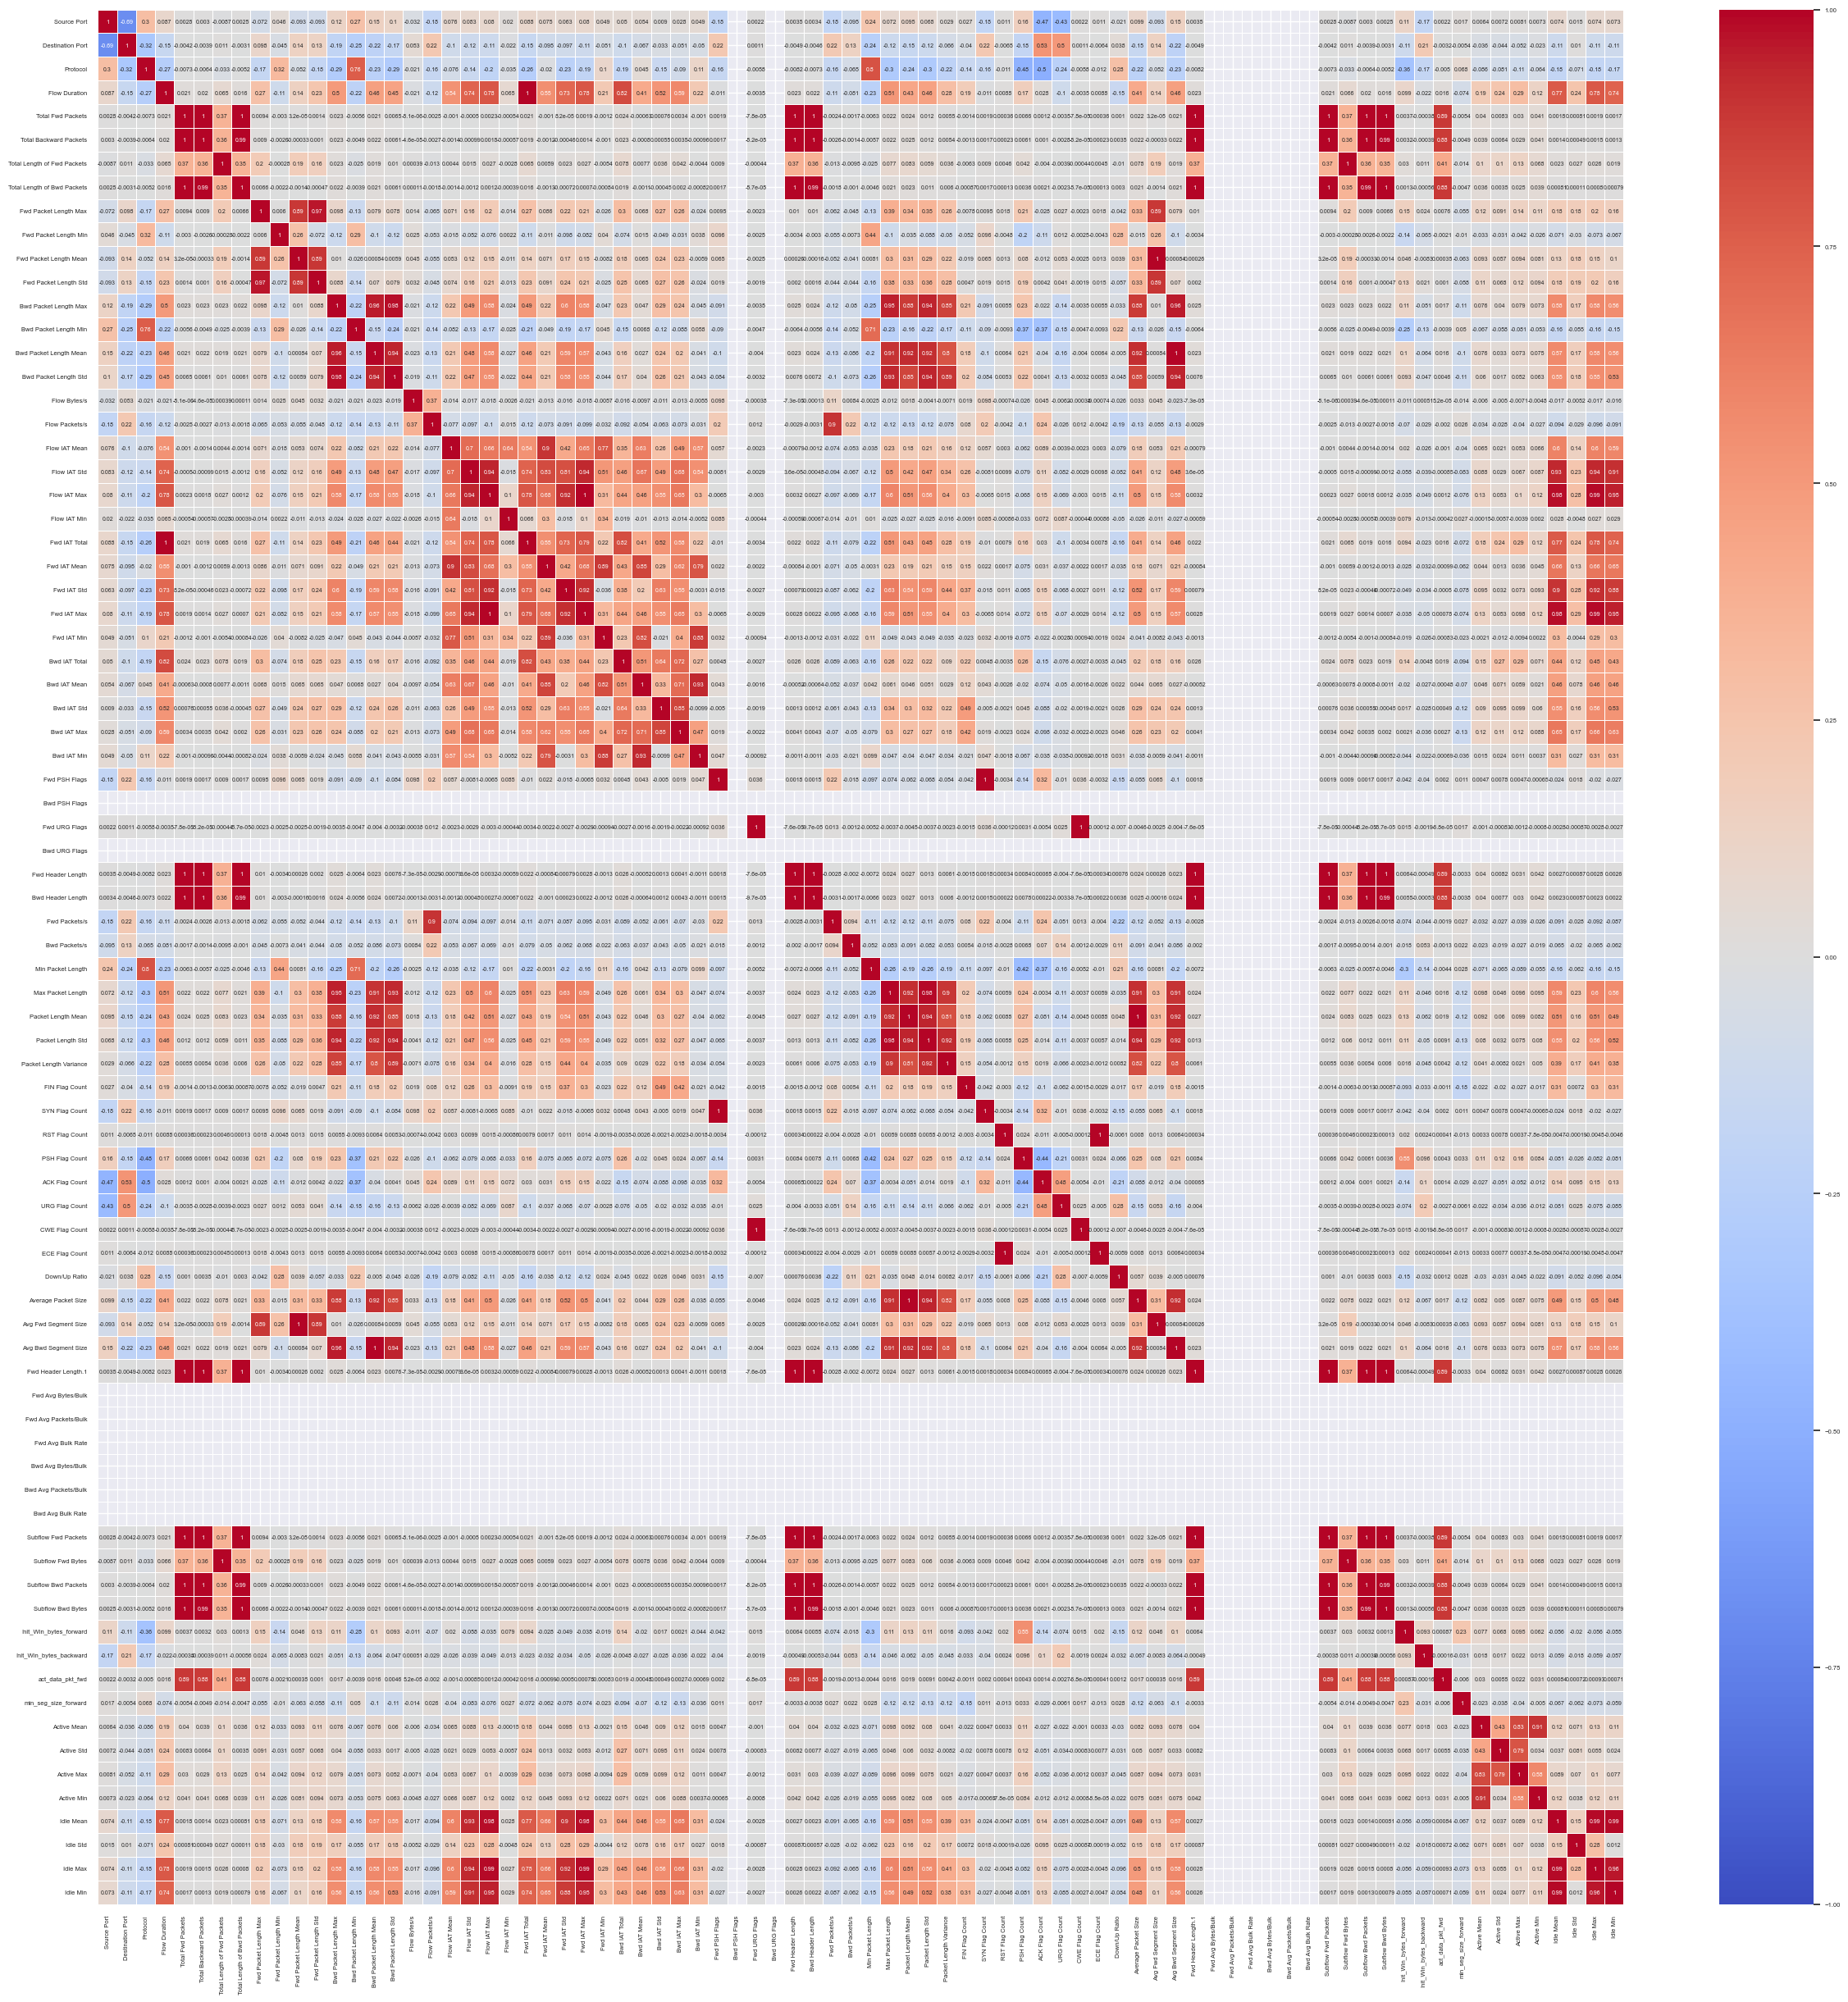

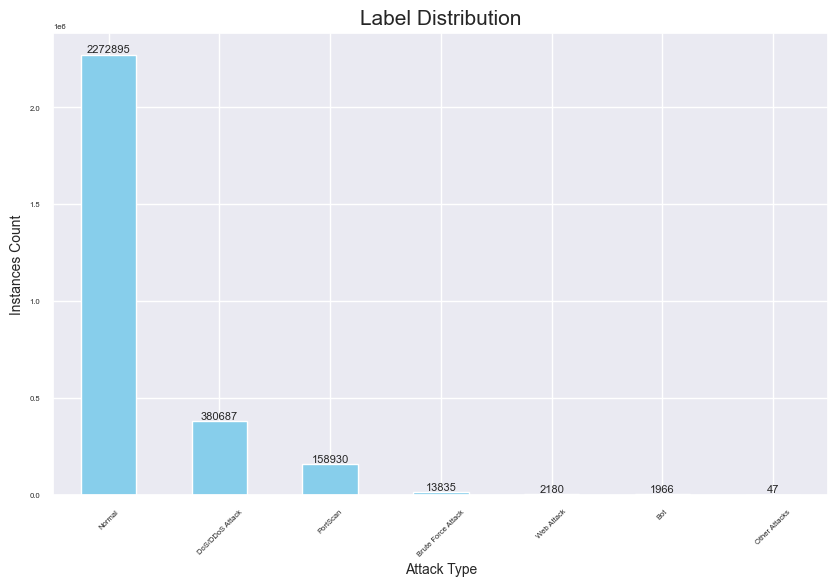

In [19]:
# print the claaes and their counts
print(df['Label'].value_counts())

# merging classes having similar attack types
def categorize_label(label):
    if label in ['DoS Hulk', 'DoS GoldenEye', 'DoS slowloris', 'DoS Slowhttptest', 'DDoS']:
        return 'DoS/DDoS Attack'
    elif label in ['Web Attack-Brute Force', 'Web Attack-XSS', 'Web Attack-Sql Injection']:
        return 'Web Attack'
    elif label in ['FTP-Patator', 'SSH-Patator']:
        return 'Brute Force Attack'
    elif label == 'Bot':
        return 'Bot'
    elif label in ['Infiltration', 'Heartbleed']:
        return 'Other Attacks'
    else:
        return label

df['Label'] = df['Label'].apply(categorize_label)

# correlation matrix 
df_corr = df[numeric_columns].corr()
fig = plt.figure(figsize=(30, 30))
sns.set(font_scale=0.5)
ax = sns.heatmap(df_corr, cmap="coolwarm", annot=True, vmin=-1,center=0, vmax=1, linewidths=.5,annot_kws={"size": 5})
plt.show()

# remove correlated features with threshold of 0.98
mask = np.triu(np.ones_like(df_corr, dtype=bool))
tri_core_df = df_corr.mask(mask)
correlated_features = [i for i in tri_core_df.columns if any(tri_core_df[i] > 0.98)]
df.drop(labels=correlated_features, axis=1, inplace=True)

# plot distribution of labels after merging and removing correlated features
plt.figure(figsize=(10,6))
df['Label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Label Distribution', fontsize=15)
plt.xlabel('Attack Type', fontsize=10)
plt.ylabel('Instances Count', fontsize=10)
plt.xticks(rotation=45)
for i, v in enumerate(df['Label'].value_counts()):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=8)
plt.show()

We can see that the data is still highly imbalanced, so we will balance the data using the following steps:
- First, we will drop the "Other Attacks" class as it has very few instances and the dataset is already large enough.
- Second, each class with more than 7000 instances will be downsampled to 7000 instances.
- Third, the remaining classes will be upsampled to 7000 instances using Synthetic Minority Over-sampling Technique (SMOTE).

Label
Normal                2272895
DoS/DDoS Attack        380687
PortScan               158930
Brute Force Attack      13835
Web Attack               2180
Bot                      1966
Name: count, dtype: int64
Label
Normal                7000
Brute Force Attack    7000
DoS/DDoS Attack       7000
PortScan              7000
Web Attack            2180
Bot                   1966
Name: count, dtype: int64


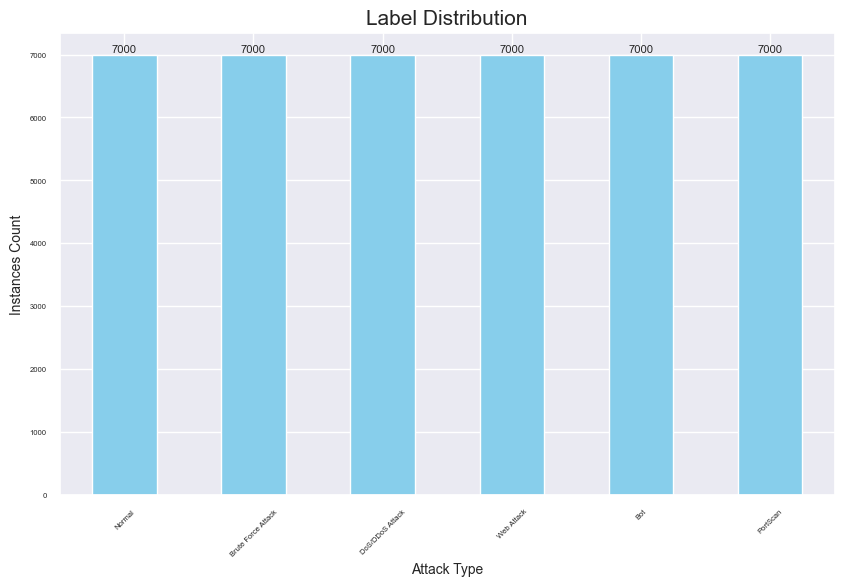

In [20]:
# remove 'Other Attacks' class
df = df[df['Label'] != 'Other Attacks']
print(df['Label'].value_counts())

# downsample classes with more than 7000 instances
downsampled_classes = []
for label in df['Label'].unique():
    if df[df['Label'] == label].shape[0] > 7000:
        downsampled_classes.append(label)
        df_class = df[df['Label'] == label]
        df = df.drop(df_class.sample(n=df_class.shape[0] - 7000, random_state=42).index)
print(df['Label'].value_counts())
        
# encode categorical features before using SMOTE
label_encoder = LabelEncoder()
for column in df.columns:
    if column != 'Label' and df[column].dtype == 'object':
        df[column] = label_encoder.fit_transform(df[column])
        
#upsample remaining classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X = df.drop('Label', axis=1)
y = df['Label']
X_smote, y_smote = smote.fit_resample(X, y)
df = pd.concat([X_smote, y_smote], axis=1)

# plot distribution of labels after balancing
plt.figure(figsize=(10,6))
df['Label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Label Distribution', fontsize=15)
plt.xlabel('Attack Type', fontsize=10)
plt.ylabel('Instances Count', fontsize=10)
plt.xticks(rotation=45)
for i, v in enumerate(df['Label'].value_counts()):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=8)
plt.show()  



## Data Splitting
we will split the data into three sets: training set (70%), validation set (15%), and testing set (15%).

In [21]:
X = df.drop('Label', axis=1)
y = df['Label']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

## Model Training and Evaluation
We train three different models - **Random Forest Classifier, AdaBoost Classifier**, and Knn Classifier on the training data.

Then, we evaluate the performance of the models using the F1 score metric on the validation data to select the best model.

In [22]:
models = [
    ("Random Forest",RandomForestClassifier(random_state = 42)),
    ("AdaBoost Classifier",AdaBoostClassifier()),
    ("Knn Classifier",KNeighborsClassifier())
]

scores = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    score = f1_score(y_val, y_pred, average='weighted')
    scores.append((name, score))
    
for name, score in scores:
    print(f'{name} F1 score: {score}')

Random Forest F1 score: 0.9995238091998703
AdaBoost Classifier F1 score: 0.23996103869750202
Knn Classifier F1 score: 0.9779129155234547


### Hyperparameter Tuning
We found that the Random Forest Classifier has the highest F1 score on the validation data.
Next we attempt to improve the performance of the random forest classifier by testing different values for the hyper parameters. 
We try different numbers of trees in the forest (n_estimators hyper-parameter) and different depths for each tree (max_depth hyper-parameter) and test how each one affects the score.

In [23]:
model = RandomForestClassifier(random_state=42)
n_estimators = [5, 10, 15]
max_depths = [5, 10, 15]
scores = []
for n in n_estimators:
    for d in max_depths:
        model.set_params(n_estimators=n, max_depth=d)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        score = f1_score(y_val, y_pred, average='weighted')
        scores.append((n, d, score))
        
for n, d, score in scores:
    print(f'n_estimators={n}, max_depth={d} F1 score: {score}')

n_estimators=5, max_depth=5 F1 score: 0.9857960799713102
n_estimators=5, max_depth=10 F1 score: 0.9979374764336529
n_estimators=5, max_depth=15 F1 score: 0.9993650790771333
n_estimators=10, max_depth=5 F1 score: 0.9907806712115514
n_estimators=10, max_depth=10 F1 score: 0.9987306092619708
n_estimators=10, max_depth=15 F1 score: 0.9996825393945936
n_estimators=15, max_depth=5 F1 score: 0.9909416661421205
n_estimators=15, max_depth=10 F1 score: 0.9990480696514176
n_estimators=15, max_depth=15 F1 score: 0.9995238091998703


We found that the best hyper-parameters for the random forest classifier are n_estimators=15 and max_depth=15.

#### Final Model Evaluation on Test Data
Finally, we will evaluate the model with the best hyperparameters on the testing data set to ensure that the model doing well on unseen data.

In [24]:
model.set_params(n_estimators=15, max_depth=15)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred, average='weighted')
print(f'Random Forest Classifier F1 score on testing data: {score}')

Random Forest Classifier F1 score on testing data: 0.9996825396105533
